In [2]:
import numpy as np
import cv2 as cv
import glob
import csv
import matplotlib.pyplot as plt

# Write frames as images

In [3]:
movienames = glob.glob('*.MOV')
for i in range(len(movienames)):
    cap = cv.VideoCapture(movienames[i])
    if not cap.isOpened():
        print("Error opening video file")
        exit()
        
    frame_number = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_number += 1
        if frame_number % 60 == 0:
            if not cv.imwrite(r"C:\Users\darren\Desktop\BR2 Camera Calibration workspace\frame" + str(int(frame_number/60)) + "cam" + str(i+1)+ ".png", frame):
                print("image could not be saved.")

# Perform Calibration

In [3]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:7].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('*cam1.png')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (9,7), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)




In [13]:
csv_file_path = r'C:\Users\darren\Desktop\BR2 Camera Calibration workspace\csv\6.17.23cam1.csv'

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(mtx)
    writer.writerows(dist)
    for array in rvecs:
        writer.writerow(array[:,0])
    for array in tvecs:
        writer.writerow(array[:,0])

# Re-projection Error


total error: 0.04804185476324459


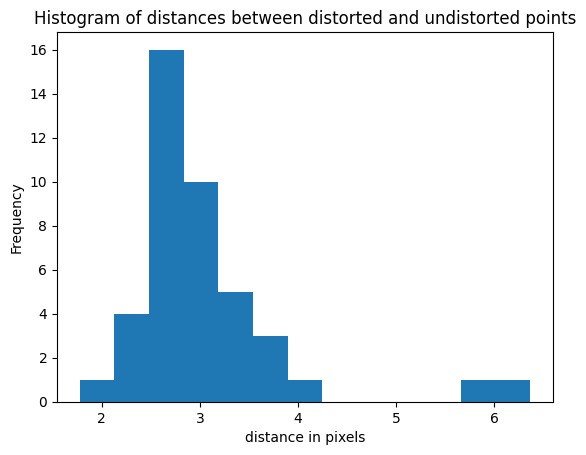

In [14]:
mean_error = 0
data = []
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    data.append(error*len(imgpoints2))
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

plt.hist(data, bins='auto')
plt.xlabel('distance in pixels')
plt.ylabel('Frequency')
plt.title('Histogram of distances between distorted and undistorted points')
plt.show()

In [7]:
#testing code

In [6]:
import cv2

frame = cv2.imread("./frame7cam1.png")
h, w = frame.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# undistort
dst = cv2.undistort(frame, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

cv2.imshow("degas",dst)
cv2.waitKey(0)
cv2.destroyAllWindows()